K-Means performance evaluation

CIFAR-10

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import torch

np.random.seed(0)

def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar10_data(data_dir, negatives=False):
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []


    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))

    cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.uint8)
    cifar_train_labels = np.array(cifar_train_labels)


    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.uint8)

    #cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_labels, cifar_test_data, cifar_test_labels

def flatten_data(x):
    samples = x.shape[0]
    flattened_shape = 1
    for dim in x.shape[1:]:
        flattened_shape *= dim
    return x.reshape(samples, flattened_shape)

def generate_kmeans_model(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    transformed = kmeans.fit_predict(X)
    return kmeans, transformed

def pca_encode(pca_model, X):
    return pca_model.transform(X)

def pca_decode(pca_model, X):
    return pca_model.inverse_transform(X)

def clusters_to_index(cluster_labels):
    dict = {}
    for i in range(len(cluster_labels)):
        if cluster_labels[i] in dict:
            dict[cluster_labels[i]].append(i)
        else:
            dict[cluster_labels[i]] = [i]
    return dict

# reconstruct data from N*3072 to N*32*32*3
def construct_image_from_flattern(x, colored = True):
    samples = x.shape[0]
    if colored:
      return x.reshape(samples, 32, 32, 3).astype("uint8")
    else:
      return x.reshape(samples, 32, 32).astype("uint8")

#visualize image data, displayed on row*col grid, x's 1st-dim >= (row*col)
def visualize_data(x, n, ncol, plt_size):
    nrow = n // ncol + 1
    #fig, axes1 = plt.subplots(nrows=nrow, ncols=ncol)
    plt.figure(figsize=(plt_size, plt_size))
    for i in range(n):
        #if i == n: break
        plt.subplot(nrow, ncol, i+1)
        plt.axis("off")
        plt.imshow(x[i])
        #axes1[k].set_axis_off()
        #axes1[k].imshow(x[k])
    plt.tight_layout()
    plt.show()
    return
    
# visualizing kmeans cluster centers
def visualize_kmeans_centre(kmeans_model, pca_model, n, ncol, colored = True):
    cluster_centers = kmeans_model.cluster_centers_
    cluster_centers_decoded = pca_decode(pca_model, cluster_centers)
    cluster_centers_decoded_image = construct_image_from_flattern(cluster_centers_decoded, colored)
    visualize_data(cluster_centers_decoded_image, n, ncol, 15)

def elbow_method(data, n_range, method='inertia'):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    for k in n_range:
        # Building and fitting the model
        km = KMeans(n_clusters=k).fit(data)
        km.fit(data)
    
        distort = sum(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0]
        distortions.append(distort)
        inertias.append(km.inertia_)
    
        mapping1[k] = sum(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0]
        mapping2[k] = km.inertia_

    if method == 'inertia':
        plt.plot(n_range, inertias, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Inertia')
        plt.title('The Elbow Method using Inertia')
        plt.show()
    elif method == 'distortion':
        plt.plot(n_range, distortions, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method using Distortion')
        plt.show()
    else:
        raise ValueError("Method not supported")


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    #estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    kmeans_model = kmeans.fit(data)
    fit_time = time() - t0
    #results = [name, fit_time, kmeans_model.inertia_]
    results = [name, fit_time]
    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        #metrics.homogeneity_score,
        #metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.normalized_mutual_info_score,
    ]
    results += [m(labels, kmeans_model.labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            kmeans_model.labels_,
            metric="euclidean",
            #sample_size=300,
        ),
        metrics.calinski_harabasz_score(data, kmeans_model.labels_)
    ]

    # Show the results
    formatter_result = (
        #"{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t{:.3f}"
        "{:9s}\t{:.3f}s\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}"
    )
    print(formatter_result.format(*results))

    return kmeans_model

def select_data(data, labels, class_of_interest, class_size):

    n = len(class_of_interest)
    
    arr_size = int(n*class_size)
    print(arr_size)
    data_new = np.empty((arr_size, *data[0].shape))
    labels_new = np.empty((arr_size, ))

    #data_sel = np.empty((0, *data[0].shape))
    #label_sel = np.empty((0, ))
    for i in range(n):
        indices = np.argwhere(labels == class_of_interest[i]).squeeze()
        indices = indices[:class_size]
        #indices = np.random.permutation(indices)[:class_size]

        data_new[i*class_size : (i+1)*class_size] = (data[indices] / 255).astype(np.float)
        labels_new[i*class_size : (i+1)*class_size] = labels[indices].astype(np.uint8)

    np.random.seed(0)
    indices_new = np.random.permutation(arr_size)
    data_new = data_new[indices_new]
    labels_new = labels_new[indices_new]

    return data_new, labels_new
    # for i, (img, label) in enumerate(zip(data, labels)):



2000
(2000, 32, 32, 3)
(2000,)


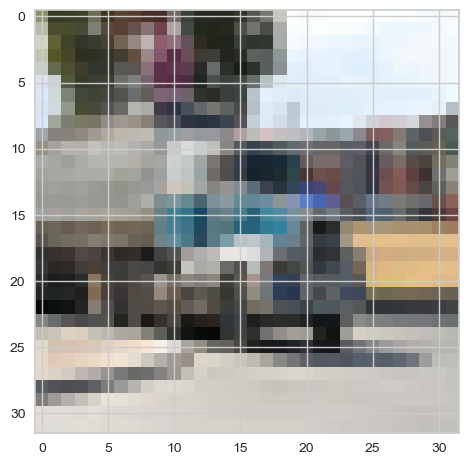

(2000, 3072)


In [120]:
cifar_10_dir = 'cifar-10-batches-py'
# load data
train_data, train_labels, test_data, test_labels = load_cifar10_data(cifar_10_dir)
X, y = select_data(train_data, train_labels, class_of_interest=[1, 7, 8, 9], class_size=500)
print(X.shape)
print(y.shape)
plt.imshow(X[100])
plt.show()
# print(y[501])
# 
# flatten data
# train_vec = flatten_data(train_data)
# test_vec = flatten_data(test_data)
# print(train_vec.shape)
X_flat = flatten_data(X)
print(X_flat.shape)

In [130]:
from Siamese import CNN
import os
# for emb_size in [1, 5]

def load_SNN(vec_size):
    net = CNN(embSize=vec_size)
    path = os.path.join('Siamese', 'models', f'siameseArchEmb{str(vec_size)}Run3.pth')
    net = torch.load(path)
    net.eval()
    return net

def get_SNN_vec(net, X):
    # Siamese Feature Vector
    feature_vec = []
    for i in range(X.shape[0]):
        img = torch.from_numpy(X[i].transpose(2, 0, 1)).type(torch.FloatTensor)
        out = torch.squeeze(net(img)).detach().numpy()
        feature_vec.append(out)

    feature_vec = np.array(feature_vec)
    #print(feature_vec.shape)
    return feature_vec

In [121]:
# CIFAR10DataVal = np.load('CIFARValData.npz')['arr_0']

# data = []
# labels = []
# for classno, classimg in enumerate(CIFAR10DataVal):
#     for i in range(len(classimg)):
#         data.append(classimg[i]/255)
#         labels.append(classno)

(2000, 5)


(2000, 5)
Feature vector size:  5


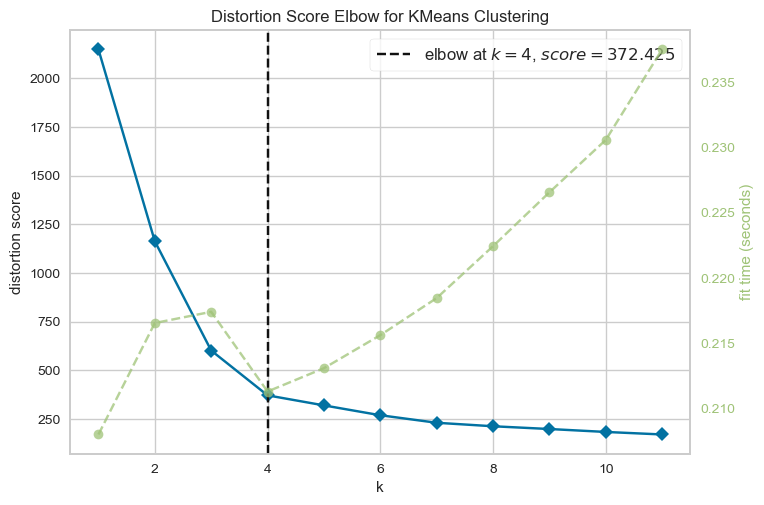

(2000, 10)
Feature vector size:  10


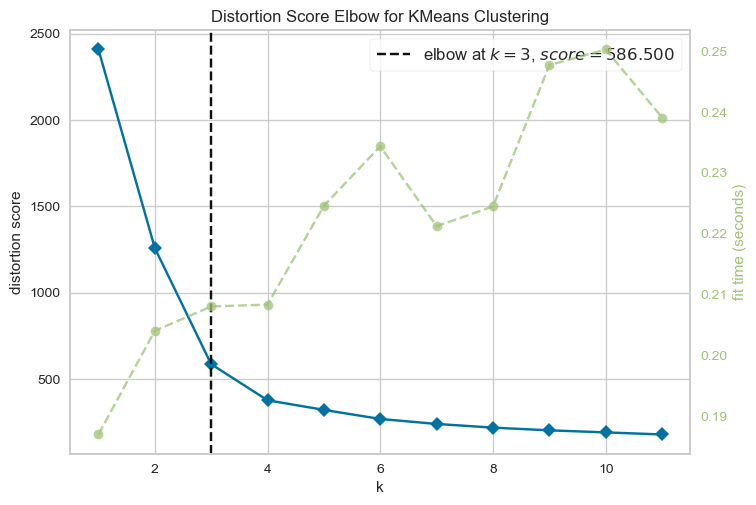

(2000, 20)
Feature vector size:  20


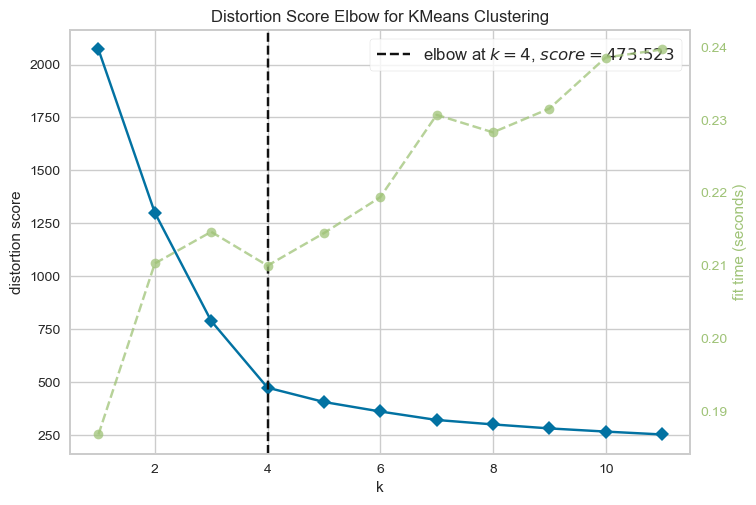

(2000, 50)
Feature vector size:  50


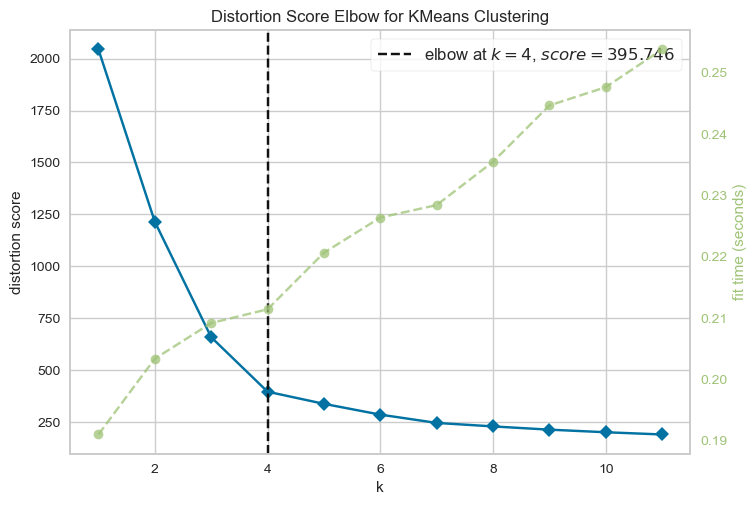

In [128]:
from yellowbrick.cluster import KElbowVisualizer

# #PCA
# feature_vector_size = 50
# pca_model = PCA(n_components=feature_vector_size).fit(test_vec)
# encoded = pca_model.transform(test_vec)
# print(encoded.shape)

# test for optimal k using elbow plot
# elbow method 
# elbow_method(X, range(1,10), method='inertia')
for vec_size in [5, 10, 20, 50]:
    SNN = load_SNN(vec_size)
    X_vec = get_SNN_vec(SNN, X)
    model = KMeans()
    visualizer1 = KElbowVisualizer(model, k=(1,12))
    #visualizer2 = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz')
    print("Feature vector size: ", vec_size)
    visualizer1.fit(X_vec)        # Fit the data to the visualizer
    visualizer1.show()        # Finalize and render the figure
    # visualizer2.fit(X_vec)        
    # visualizer2.show()        

In [138]:
# test performance with different number of cluster / PCA feature vector size

print("Evaluating PCA ...")
print(100 * "_")
#print("init\t\ttime\tinertia\t\thomo\tcompl\tv-meas\tARI\tNMI\tsilhouette\tcalinski\tdavies")
print("init\t\ttime\tv-meas\tARI\tNMI\tsilhouette\tcalinski")

for n_clusters in [3, 4, 5]:
    for feature_vector_size in [10, 50, 100, 200]:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        pca_model = PCA(n_components=feature_vector_size).fit(X_flat)
        encoded = pca_model.transform(X_flat)
        #print(encoded.shape)
        kmeans_pca = bench_k_means(kmeans, name="PCA-" + "n" + str(n_clusters) + "v" + str(feature_vector_size), data=encoded, labels=y)

print(100 * "_")

Evaluating PCA ...
____________________________________________________________________________________________________
init		time	v-meas	ARI	NMI	silhouette	calinski
PCA-n3v10	0.221s	0.047	0.046	0.047	0.162		515.248
PCA-n3v50	0.226s	0.047	0.045	0.047	0.115		340.252
PCA-n3v100	0.231s	0.048	0.046	0.048	0.106		307.568
PCA-n3v200	0.229s	0.048	0.046	0.048	0.099		286.363
PCA-n4v10	0.243s	0.045	0.040	0.045	0.152		436.415
PCA-n4v50	0.230s	0.046	0.040	0.046	0.107		279.542
PCA-n4v100	0.244s	0.048	0.043	0.048	0.097		251.305
PCA-n4v200	0.247s	0.048	0.043	0.048	0.091		233.178
PCA-n5v10	0.244s	0.071	0.064	0.071	0.139		382.018
PCA-n5v50	0.241s	0.073	0.064	0.073	0.095		239.125
PCA-n5v100	0.241s	0.074	0.066	0.074	0.085		214.095
PCA-n5v200	0.261s	0.073	0.065	0.073	0.080		198.131
____________________________________________________________________________________________________


In [140]:
print("\nEvaluating Siamese ...")
print(100 * "_")
#print("init\t\ttime\tinertia\t\thomo\tcompl\tv-meas\tARI\tNMI\tsilhouette\tcalinski\tdavies")
print("init\t\ttime\tv-meas\tARI\tNMI\tsilhouette\tcalinski")

for n_clusters in [3, 4, 5]:
    for feature_vector_size in [5, 10, 20, 50]:
        SNN = load_SNN(feature_vector_size)
        X_vec = get_SNN_vec(SNN, X)
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans_siamese = bench_k_means(kmeans, name="SNN-" + "n" + str(n_clusters) + "v" + str(feature_vector_size), data=X_vec, labels=y)

print(100 * "_")


Evaluating Siamese ...
____________________________________________________________________________________________________
init		time	v-meas	ARI	NMI	silhouette	calinski
SNN-n3v5 	0.206s	0.653	0.567	0.653	0.521		2561.402
SNN-n3v10	0.201s	0.645	0.567	0.645	0.550		3100.761
SNN-n3v20	0.207s	0.637	0.565	0.637	0.440		1624.168
SNN-n3v50	0.211s	0.630	0.534	0.630	0.504		2102.817
SNN-n4v5 	0.206s	0.653	0.631	0.653	0.512		3172.363
SNN-n4v10	0.204s	0.648	0.645	0.648	0.523		3576.867
SNN-n4v20	0.205s	0.647	0.652	0.647	0.476		2244.891
SNN-n4v50	0.213s	0.657	0.638	0.657	0.513		2771.699
SNN-n5v5 	0.207s	0.643	0.599	0.643	0.469		2838.719
SNN-n5v10	0.221s	0.635	0.606	0.635	0.483		3229.843
SNN-n5v20	0.211s	0.632	0.616	0.632	0.437		2046.371
SNN-n5v50	0.216s	0.640	0.613	0.640	0.472		2523.762
____________________________________________________________________________________________________


0


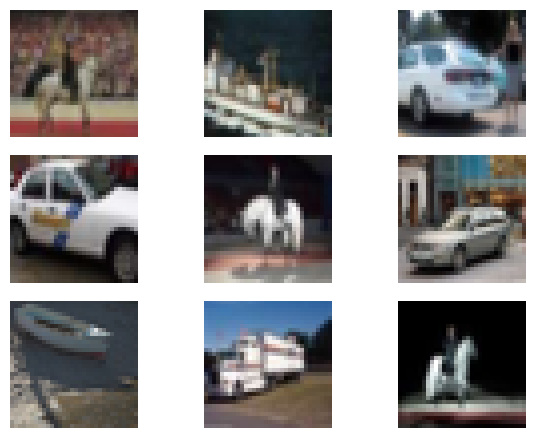

1


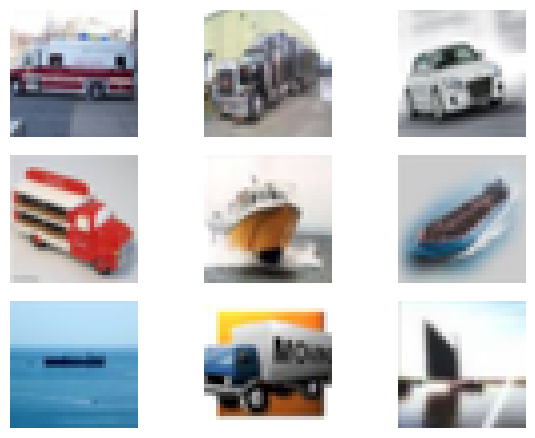

2


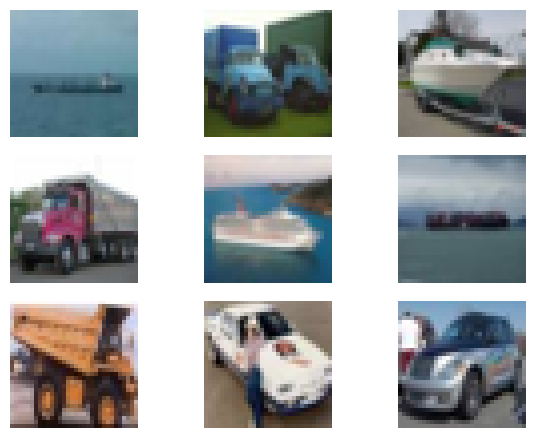

3


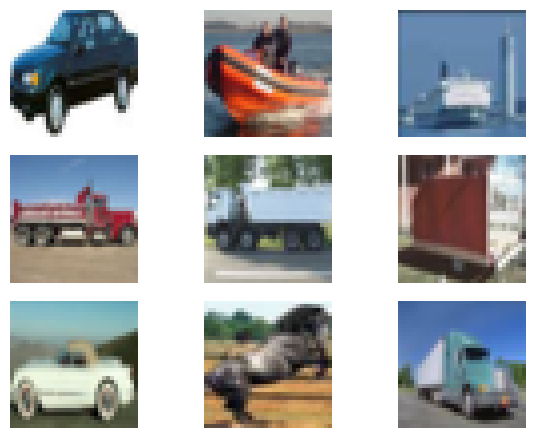

In [142]:
# PCA
kmeans = KMeans(n_clusters=4, random_state=0)
pca_model = PCA(n_components=20).fit(X_flat)
encoded = pca_model.transform(X_flat)
kmeans_pca = kmeans.fit(encoded)

# visualize_kmeans_centre(kmeans_model1, pca_model, n=n_clusters, ncol=n_clusters)

cluster_index_dict = clusters_to_index(kmeans_pca.labels_)
for cluster in sorted(list(cluster_index_dict.keys())):
    print(cluster)
    image_index = cluster_index_dict[cluster]
    images = X[image_index]
    visualize_data(images, n=9, ncol=3, plt_size=6)

0


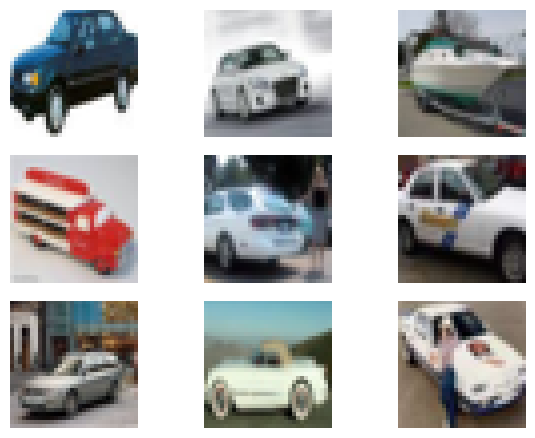

1


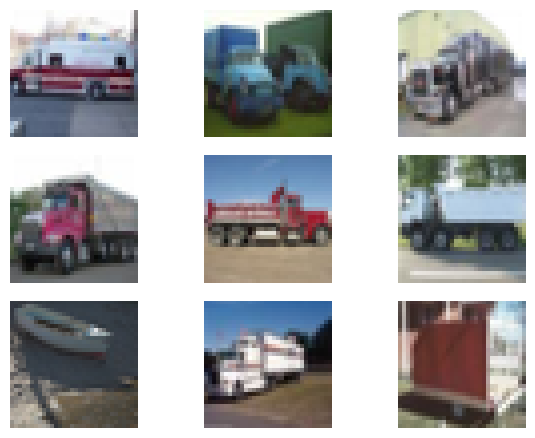

2


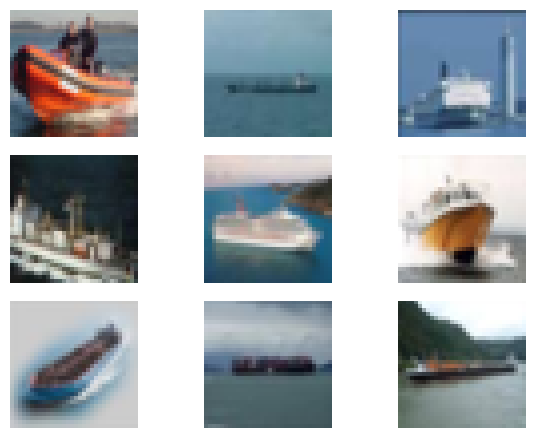

3


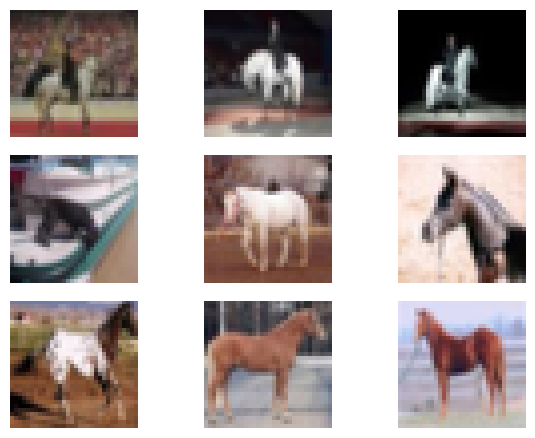

In [143]:
# siamese
kmeans = KMeans(n_clusters=4, random_state=0)
SNN = load_SNN(vec_size=20)
X_vec = get_SNN_vec(SNN, X)
kmeans_siamese = kmeans.fit(X_vec)

# visualize
cluster_index_dict = clusters_to_index(kmeans_siamese.labels_)
for cluster in sorted(list(cluster_index_dict.keys())):
    print(cluster)
    image_index = cluster_index_dict[cluster]
    images = X[image_index]
    visualize_data(images, n=9, ncol=3, plt_size=6)

(1000, 2)
11176.658063383722
7485.513516199147


c:\Users\junbo\anaconda3\envs\csc2515\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


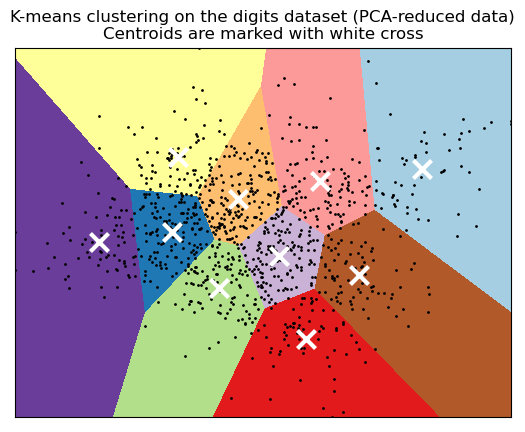

In [87]:
# visualizing clusters
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(test_vec)[0:1000]
print(reduced_data.shape)
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 2  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
print(x_max - x_min)
print(y_max - y_min)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on cifar10 dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [15]:
from sklearn import metrics
print(metrics.rand_score(labels, test_labels))
print(metrics.adjusted_rand_score(labels, test_labels))
print(metrics.adjusted_mutual_info_score(labels, test_labels))
print(metrics.normalized_mutual_info_score(labels, test_labels))
# metrics.homogeneity_score(labels_true, labels_pred)
# metrics.completeness_score(labels_true, labels_pred)
# metrics.v_measure_score(labels_true, labels_pred)
print(metrics.homogeneity_completeness_v_measure(labels, test_labels))
print(metrics.silhouette_score(encoded, labels, metric='euclidean'))
#print(metrics.adjusted_rand_score([0,0,1,1,2,2], [4,4,5,5,6,6]))

NameError: name 'labels' is not defined

In [54]:
x = np.array([122,3,52,3,3,21,12])
a = np.argwhere(x == 3).squeeze()
print(a)
print(np.random.permutation(a))

[1 3 4]
[3 4 1]


In [45]:
b = np.array([])
c = np.ones(2)
print(c.shape)
b = np.concatenate((b, c), axis=0)
b = np.concatenate((b, c), axis=0)
print(b.shape)

(2,)
(4,)
